## Stack of LogRegs to Approximate NN

Let's see if we can use multiple logistic regression models to approximate a neural network.

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

First let's make ourselves a classification problem.

In [156]:
X, y = make_classification(n_features=10,
                           n_samples=1000,
                           n_informative=8,
                           n_redundant=0,
                           n_clusters_per_class=4,
                           flip_y=0.25,
                           random_state=42)

Let's see how a vanilla logistic regression does on our data.

In [157]:
LogisticRegression().fit(X, y).score(X, y)

0.661

### Input Layer

OK. Let's get building!

We'll start by building our first layer of neurons. Each neuron will be a logistic regression model, one for each of our ten features.

In [160]:
n_samples = X.shape[0]
n_features = X.shape[1]

input_layer = []
for j in range(n_features):
    logreg = LogisticRegression()
    
    # Fit each model to a single feature
    pred = X[:, j].reshape(-1, 1)
    logreg.fit(pred, y)
    input_layer.append(logreg)

Now let's generate all of these models' predictions, so that we can send them on to the next layer.

In [161]:
preds = np.zeros((n_samples, n_features))

for j in range(n_features):
    
    # Grabbing the predicted probability for class=1
    pred = input_layer[j].predict_proba(X[:, j].reshape(-1, 1))
    preds[:, j] = [pct[1] for pct in pred]

In [162]:
LogisticRegression().fit(preds, y).score(preds, y)

0.663

### Hidden Layer

We have a design choice to make for the hidden layer. Connecting this layer densely with the last will mean that each of our input layer's models' predictions will be inputs to each of the models in the hidden layer. Let's choose five nodes for this layer.

We're going to assign a random set of weights to each connection: Each model in the hidden layer will receive a differently weighted set of predictions from the ten models in the input layer. This will ensure that the models in the hidden layer won't be identical.

In [163]:
n_input_models = n_features
n_hidden_nodes = 5

hidden_layer = []
for j in range(n_hidden_nodes):
    logreg = LogisticRegression()
    rand_weights = np.random.rand(n_input_models)
    inputs = np.array([rand_weights[j] * preds[:, j] for j in range(n_input_models)]).T
    logreg.fit(inputs, y)
    hidden_layer.append(logreg)

Now we need to generate the predictions from the models in the hidden layer.

In [176]:
h_preds = np.zeros((n_samples, n_features))

for j in range(n_hidden_nodes):
    h_pred = hidden_layer[j].predict_proba(preds)
    h_preds[:, j] = [pct[1] for pct in h_pred]

Finally, we'll fit a final model to the predictions from the nodes in the hidden layer.

In [181]:
output = LogisticRegression()

output.fit(h_preds, y)

LogisticRegression()

In [182]:
output.score(h_preds, y)

0.65

## NN by Hand

Let's try giving ourselves more control over the weights. We'll make a much simpler network.

In [284]:
from sklearn.datasets import make_regression

In [285]:
X, y = make_regression(n_features=2,
                       n_informative=1,
                       noise=100,
                       random_state=42)

In [286]:
from sklearn.linear_model import LinearRegression

In [287]:
LinearRegression().fit(X, y).score(X, y)

0.4144461358278726

Let's imagine that we have just a five-neuron network: two input neurons, two hidden-layer neurons, and a single output neuron.

In [288]:
n_samples = X.shape[0]
n_features = X.shape[1]

# Initial inputs
input1 = X[:, 0].reshape(-1, 1)
input2 = X[:, 1].reshape(-1, 1)

In [289]:
# Four weights to optimize for between input
# and hidden layers

# For simplicity let's assume biases of 0
# throughout

in_hid_weights1 = np.random.rand(2)
in_hid_weights2 = np.random.rand(2)

In [290]:
in1_to_hid = (np.sum(np.product([in_hid_weights1, X], axis=0), axis=1)).reshape(-1, 1)
in2_to_hid = (np.sum(np.product([in_hid_weights2, X], axis=0), axis=1)).reshape(-1, 1)

For simplicity let's assume a linear activation function in the hidden nodes.

On to the output neuron!

In [291]:
hid_out_weights = np.random.rand(2)

In [292]:
joint_to_out = np.hstack((in1_to_hid, in2_to_hid))

In [293]:
output = (np.sum(np.product([hid_out_weights, joint_to_out], axis=0), axis=1)).reshape(-1, 1)

Again we'll assume a linear activation.

Now we can compute a measure of error:

In [294]:
from sklearn.metrics import mean_squared_error as mse

In [295]:
output = output.flatten()

np.sqrt(mse(y, output))

132.2387968724149

### Backpropagation

Now then: How do we make corrections to our weights to improve our model's performance? Our network looks like this:

![nn](SimpleNN.png)

Clearly our output is a function of these six weights. But what function, exactly?

- In the top hidden node we construct: <br/> $H_1 = w_1X_1 + w_3X_2$ <br/> and in the bottom node we construct: <br/> $H_2 = w_2X_1 + w_4X_2$.
<br/> <br/>
- In the output node we construct: <br/> $\hat{y} = w_5H_1 + w_6H_2$ <br/> i.e. <br/> $\hat{y} = w_5(w_1X_1 + w_3X_2) + w_6(w_2X_1 + w_4X_2)$ <br/> or <br/> $\hat{y} = X_1(w_1w_5 + w_2w_6) + X_2(w_3w_5 + w_4w_6)$.

#### Loss Function

Our loss function (let's assume) is just $\mathcal{L} = \Sigma\left(y - \hat{y}\right)^2$. What are the partial derivatives of this function?

We have $\mathcal{L} = \Sigma\left(y - [X_1(w_1w_5 + w_2w_6) + X_2(w_3w_5 + w_4w_6)]\right)^2$.

Therefore:

- $\frac{\partial\mathcal{L}}{\partial w_1} = -2w_5X_1\Sigma\left(y - [X_1(w_1w_5 + w_2w_6) + X_2(w_3w_5 + w_4w_6)]\right)$

- $\frac{\partial\mathcal{L}}{\partial w_2} = -2w_6X_1\Sigma\left(y - [X_1(w_1w_5 + w_2w_6) + X_2(w_3w_5 + w_4w_6)]\right)$

- $\frac{\partial\mathcal{L}}{\partial w_3} = -2w_5X_2\Sigma\left(y - [X_1(w_1w_5 + w_2w_6) + X_2(w_3w_5 + w_4w_6)]\right)$

- $\frac{\partial\mathcal{L}}{\partial w_4} = -2w_6X_2\Sigma\left(y - [X_1(w_1w_5 + w_2w_6) + X_2(w_3w_5 + w_4w_6)]\right)$

- $\frac{\partial\mathcal{L}}{\partial w_5} = -2(w_1X_1 + w_3X_2)\Sigma\left(y - [X_1(w_1w_5 + w_2w_6) + X_2(w_3w_5 + w_4w_6)]\right)$

- $\frac{\partial\mathcal{L}}{\partial w_6} = -2(w_2X_1 + w_4X_2)\Sigma\left(y - [X_1(w_1w_5 + w_2w_6) + X_2(w_3w_5 + w_4w_6)]\right)$

So the goal now should just be to nudge each of our weights in (the opposites of) these directions.

In [296]:
w1 = in_hid_weights1[0]
w2 = in_hid_weights1[1]
w3 = in_hid_weights2[0]
w4 = in_hid_weights2[1]
w5 = hid_out_weights[0]
w6 = hid_out_weights[1]

Let's build an SGD function that will adjust weights after each training sample runs through the network.

In [404]:
def grad_desc(pred1=input1, pred2=input2, y=y,
              w1=w1, w2=w2, w3=w3, w4=w4,
              w5=w5, w6=w6, times_thru=1, lr=1e-4):

    for k in range(times_thru):
    
        for j in range(pred1.shape[0]):
            
            in1_val = pred1[j]
            in2_val = pred2[j]
            
            sum_ = y[j] - in1_val*(w1*w5 + w2*w6) - in2_val*(w3*w5 + w4*w6)

            w5 += lr*(w1*in1_val + w3*in2_val)*sum_

            w6 += lr*(w2*in1_val + w4*in2_val)*sum_

            w1 += lr*w5*in1_val*sum_

            w2 += lr*w6*in1_val*sum_

            w3 += lr*w5*in2_val*sum_

            w4 += lr*w6*in2_val*sum_
            
            output = pred1*(w1*w5 + w2*w6) + pred2*(w3*w5 + w4*w6)
            
            if j == 0 and k == 0:
                print(f"""
                After a single data point our RMSE is {np.sqrt(mse(y, output.flatten()))}
                """)
            
        print(f"""
                After {k+1} epochs our RMSE is {np.sqrt(mse(y, output.flatten()))}
        """)
        
    return w1, w2, w3, w4, w5, w6

In [405]:
grad_desc(times_thru=5)


                After a single data point our RMSE is 132.28814433843758
                

                After 1 epochs our RMSE is 131.33072371660734
        

                After 2 epochs our RMSE is 127.94966625670574
        

                After 3 epochs our RMSE is 118.65042756571212
        

                After 4 epochs our RMSE is 107.35987667001076
        

                After 5 epochs our RMSE is 103.2656082883244
        


(array([7.26015417]),
 array([5.49132156]),
 array([0.88698355]),
 array([0.73744729]),
 array([7.03451694]),
 array([5.40794395]))

In [406]:
X_easy, y_easy = make_regression(n_features=2, n_informative=2, random_state=42)

In [407]:
w_easy = np.random.rand(6)

In [409]:
final_weights = grad_desc(pred1=X_easy[:, 0], pred2=X_easy[:, 1], y=y_easy,
         w1=w_easy[0], w2=w_easy[1], w3=w_easy[2],
         w4=w_easy[3], w5=w_easy[4], w6=w_easy[5],
         lr=4e-3, times_thru=3)
final_weights


                After a single data point our RMSE is 104.07629676318366
                

                After 1 epochs our RMSE is 1.573956777462879e-05
        

                After 2 epochs our RMSE is 9.770493474869423e-11
        

                After 3 epochs our RMSE is 0.0
        


(9.368487371369753,
 9.964950594105778,
 5.886780460340266,
 9.62096433110008,
 3.366289629559119,
 5.639793672749383)

### Comparing with `LinearRegression()`

We can translate these final weight values into $\beta_1$ and $\beta_2$ for a traditional linear regression $\hat{y} = \beta_1X_1 + \beta_2X_2$.

Above we calculated $\hat{y} = X_1(w_1w_5 + w_2w_6) + X_2(w_3w_5 + w_4w_6)$.

Thus we have:

- $\beta_1 = w_1w_5 + w_2w_6$, and
- $\beta_2 = w_3w_5 + w_4w_6$.

Plugging these in for our final calculated weights we have:

In [410]:
beta1 = final_weights[0]*final_weights[4] + final_weights[1]*final_weights[5]
beta2 = final_weights[2]*final_weights[4] + final_weights[3]*final_weights[5]
print(f"Our mini-NN found coefficients of {beta1} and {beta2}.")

Our mini-NN found coefficients of 87.73730719279554 and 74.07686177542044.


Let's compare these numbers with the results of `LinearRegression()`:

In [411]:
from sklearn.linear_model import LinearRegression

In [412]:
LinearRegression(fit_intercept=False).fit(X_easy, y_easy).coef_

array([87.73730719, 74.07686178])

In [1]:
from scipy import stats

In [3]:
stats.norm.cdf(2, 1.4, 0.4)

0.9331927987311419

In [4]:
stats.norm.cdf(1.5)

0.9331927987311419

In [39]:
from sklearn import neural_network

In [40]:
# This does not support work on a GPU!
neural_network.MLPClassifier()

MLPClassifier()

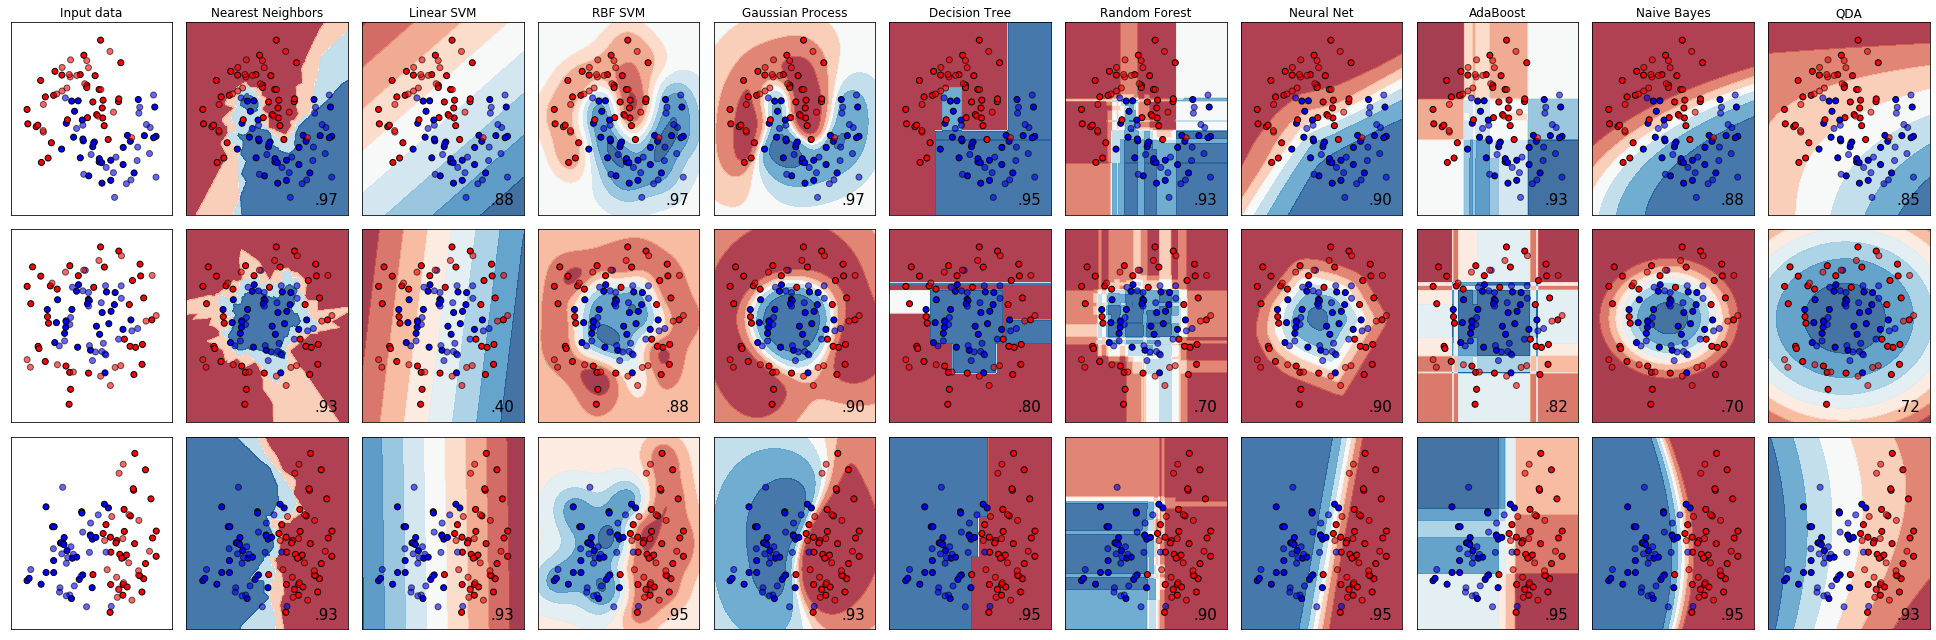

In [41]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = 0.02  # step size in the mesh

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()